# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
### Import all the libraries used in this notebook
import pickle
import sys
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import random
from collections import Counter
from tensorflow.contrib.layers import flatten



In [ ]:
# Navigate myself

# import os
os.getcwd()
#os.listdir('.')
#os.chdir('./traffic-signs-data')
#os.listdir('.')

In [2]:
# Load pickled data

# import pickle
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [ ]:
# ValueError: unsupported pickle protocol: 3, solution, check python version, used python 2(a wrong kernel)
# from six.moves import cPickle as pickle #Read pickle faster

# Check python version
# print(sys.version)

# print(pickle.HIGHEST_PROTOCOL)
# 4 in python3.5, 2 in python 2.7.11

# Notes:
# Pickle protocol is basically the file format. From the documentation, The higher the protocol used, the 
#  more recent the version of Python needed to read the pickle produced. ... Pickle protocol version 4 was 
#  added in Python 3.4, your python version (2.7.5) does not support this.
#  Either upgrade to Python 3.4 or later (current is 3.5) or create the pickle using a lower protocol (2) 
#  in the third parameter to pickle.dump()

### Self defined functions
Put all the customized function in the beginning of the notebook. Some debugging codes will appear in a sequence

In [3]:
### Convert color image to different forms
def image_tranformation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # normalize = cv2.normalize(gray)

    fig = plt.figure()
    fig.set_size_inches(5, 6)
    a=fig.add_subplot(2,2,1)
    imgplot = plt.imshow(img)
    a.set_title('Original image')


    a=fig.add_subplot(2,2,2)
    imgplot = plt.imshow(gray, cmap='gray')
    a.set_title('Convert to gray')


    equalize = cv2.equalizeHist(gray)
    a=fig.add_subplot(2,2,3)
    imgplot = plt.imshow(equalize, cmap='gray')
    a.set_title('Apply equalizer on gray')


    # create a CLAHE object (Arguments are optional).(Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    a=fig.add_subplot(2,2,4)
    imgplot = plt.imshow(cl1, cmap='gray')
    a.set_title('Apply CLAHE on gray')

    print('The class of this image is:',sign_dict[str(y_train[index])])

    
### Extract the region contains traffic sign, and resize the image to 32 by 32
def trim_resize_image(img,size,coords):
    coord = coords.reshape(2,2)
    resize = size/img.shape[0:2]
    resize_coords = coord/resize
    resize_coords_int = resize_coords.astype(int)
    trim_img = img[resize_coords_int[0,0]:resize_coords_int[1,0]+2,resize_coords_int[0,1]:resize_coords_int[1,1]+2]
    
    resize_img =  cv2.resize(trim_img,(32,32), interpolation = cv2.INTER_CUBIC)
    return resize_img


### Display first 5 images in the sequence(for debug use)
def display(images):
    for img in images:
        plt.figure()
        plt.imshow(img)

        
### Scale the image in the range of [-1,1]
def scale_image(img, a=-1,b=1):
    max_scale = 255
    min_scale = 0
    return a+(img/max_scale-min_scale)/(b-a)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
X_train, y_train,size_train, coords_train = train['features'], train['labels'],train['sizes'], train['coords']
X_test, y_test,size_test, coords_test = test['features'], test['labels'],test['sizes'], test['coords']

In [ ]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [101]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
    
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load the data dictionary for classes
signnames = csv.reader(open('signnames.csv', 'r'))

sign_dict = {}
for row in signnames:
   index, label = row
   sign_dict[index] = label

# print(sign_dict)


In [ ]:
# 1. plot the n-th traffic sign image in train set, with it's label, find the bounding box around the sign in the 
# image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.imshow(image)
print('The class of {}th image is:'.format(index),sign_dict[str(y_train[index])])

In [ ]:
### Extract the region contains traffic sign, define a function to reproduce the process, "trim_resize_image"

### For debug
# index = random.randint(0, len(X_train))
# image = X_train[index]
# print(size_train[index])
# print(coords_train[index])
# print(image.shape[0:2])
# coord = coords_train[index].reshape(2,2)
# print("Reshape coords", coord)
# resize = size_train[index]/image.shape[0:2]
# print(resize)
# resize_coords = coord/resize
# resize_coords_int = resize_coords.astype(int)
# print("Resized coords:",resize_coords_int)

# print("Resized coords: 1, 1",resize_coords_int[1,1])
# print("Resized coords: 1, 0",resize_coords_int[1,0])


# plt.imshow(image)
# plt.title('Original image')
# plt.figure()
# trim_img = image[resize_coords_int[0,0]:resize_coords_int[1,0]+2,resize_coords_int[0,1]:resize_coords_int[1,1]+2]
# plt.imshow(trim_img)
# plt.title('Trimmed image')
# resize_img =  cv2.resize(trim_img,None,fx=32, fy=32, interpolation = cv2.INTER_CUBIC)
# plt.figure()
# plt.imshow(resize_img)
# plt.title('Resized to 32 by 32')

In [5]:
### Call function trim_imgs(defined above in section "Self defined functions"), cut the image to be in coords and
# Resize it to 32 by 32
trim_imgs = [trim_resize_image(img, size, coords) for img, size, coords in zip(X_train, size_train, coords_train)]

In [ ]:
# 2. plot grayscale
image_tranformation(X_train[index])
image_tranformation(trim_imgs[index])    

In [ ]:
# 2. plot each type traffic sign count in training set(histogram)

#from collections import Counter
counts = Counter(y_train)
label_indexes = counts.keys()
label_names = [sign_dict[str(i)] for i in label_indexes]
label_counts = counts.values()

indexes = np.arange(len(label_names))

fig = plt.gcf()
fig.set_size_inches(5, 8)

plt.barh(indexes, label_counts, height = 0.7)
plt.yticks(indexes + 0.25, label_names)
plt.xlabel('Count')
plt.ylabel('Label type')
plt.title('Occurance by sign classes in training set')

# plt.savefig('SignOccurance.png', 
#             dpi= 100, # The resolution in dots per inch.
#             facecolor='w', edgecolor='w', #the colors of the figure rectangle
#             format = 'png', # One of the file extensions supported by the active backend. png, pdf, ps, eps and svg.
#             transparent=False, bbox_inches=None, pad_inches=0.1,
#             frameon=None)

plt.show()

According to the plot, even the least frequent class has more than 200 occurance, I think this is a good dataset. However we will keep this in mind and after running the model. It's important to see how each type of the traffic sign are labeled. And possible if some minor class are low, I will use some augmentation method to increase the training size(in automated way)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [ ]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.


In [ ]:
#image
#scale_image(image)

In [ ]:
#image dimension(gray scale)
#scale = scale_image(X_train[1])
# gray = cv2.cvtColor(X_train[1], cv2.COLOR_RGB2GRAY)
# print(scale.shape)
# print(gray.shape)
# reshape = gray.reshape(32, 32, 1)
# print(reshape.shape)


In [51]:
# After observation a few images, the overall image quality is not very good. CLAHE seems 
# to provide better visual seperation. But the hyper parameter change influence the image
# a lot. So go with equalized image
X_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY).reshape((32,32,1)) for i in trim_imgs]
scale = [scale_image(img) for img in X_gray]
#X_eq = [cv2.equalizeHist(i).reshape((32,32,1)) for i in X_gray]

## Check the conversion been done correctly
# for i in X_train[22243:22248]:
#     plt.figure()
#     plt.imshow(i,cmap='gray')

In [52]:
print(scale[1].shape)
# print(X_gray[1])
# print(X_train[1])

(32, 32, 1)


### Split Data into Training, Validation and Testing Sets

In [53]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

# Split the data for 70% training, 30% validation
train_index = int(0.7*len(X_train))

# print(train_index)
X_train_s, y_train_s = shuffle(scale, y_train)
x_training, x_validation = X_train_s[:train_index], X_train_s[train_index:]
y_training, y_validation = y_train_s[:train_index], y_train_s[train_index:]



In [ ]:
# ### Validate if the shuffle makes the image and label misplaced, --- not working after reshape
# index = random.randint(0, len(x_training))
# #image = X_train[index].squeeze()
# plt.imshow(x_training[index],cmap = 'gray')
# plt.title(sign_dict[str(y_training[index])])

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet_Default(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [39]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet_Changed(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout
    fc2 = tf.nn.dropout(fc2,keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [33]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [40]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
# x = tf.placeholder(tf.float32, (None, 32, 32))

y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [41]:
rate = 0.001

#logits = LeNet_Default(x)
logits = LeNet_Changed(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [42]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [56]:
EPOCHS = 15
BATCH_SIZE = 128
import time

with tf.Session() as sess:
    # Run Inference
    t = time.time()
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_training)
    training_accuracy_list = []
    validation_accuracy_list = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_training, y_training = shuffle(x_training, y_training)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_training[offset:end], y_training[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.8})
        
        training_accuracy = evaluate(x_training, y_training)
        validation_accuracy = evaluate(x_validation, y_validation)
        training_accuracy_list.append(training_accuracy)
        validation_accuracy_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time: %.3f seconds" % (time.time() - t))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.419
Validation Accuracy = 0.424
Time: 35.151 seconds

EPOCH 2 ...
Training Accuracy = 0.709
Validation Accuracy = 0.711
Time: 70.212 seconds

Model saved


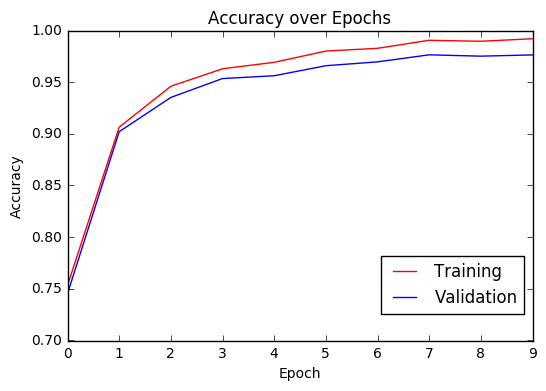

In [45]:
# Analyze the model --> plot training and validation set accuarcy. See if at some point the validation accuarcy 
# decrease --> Overfit, should reduce the number of EPOCHS 

plt.plot(range(EPOCHS), training_accuracy_list,'r-', label="Training")
plt.plot(range(EPOCHS), validation_accuracy_list,'b-', label="Validation")
#plt.xlim(0,EPOCHS)
plt.ylim(0.7,1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1, 0.3))
plt.title('Accuracy over Epochs')
plt.show()


# Use EPOCHS = 20 and create the same plot
# plt.savefig('Overfitting.png', 
#             dpi= 100, # The resolution in dots per inch.
#             facecolor='w', edgecolor='w', #the colors of the figure rectangle
#             format = 'png', # One of the file extensions supported by the active backend. png, pdf, ps, eps and svg.
#             transparent=False, bbox_inches=None, pad_inches=0.1,
#             frameon=None)

### Check overfitting issue
I ran for 20 Epochs, and save the file locally.
![Image](./Overfitting.png)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
img00 = trim_resize_image(X_test[0], size_test[0], coords_test[0])
plt.imshow(img00)
plt.figure()
plt.imshow(X_test[0])

In [46]:
## Update the trim_resize_image function before apply on test images. Due to errors in original size, for example test
# image 2847. See debuging notes below.

def trim_resize_image(img,size,coords):
    coord = coords.reshape(2,2)
    resize = size/img.shape[0:2]
    resize_coords = coord/resize
    resize_coords_int = resize_coords.astype(int)
    trim_img = img[resize_coords_int[0,0]:resize_coords_int[1,0]+2,resize_coords_int[0,1]:resize_coords_int[1,1]+2]
    # Adding Error handling capability for strange size images
    try:
        resize_img =  cv2.resize(trim_img,(32,32), interpolation = cv2.INTER_CUBIC)
        #break
    except (cv2.error): #Opencv has its own error. If anything wrong, return the original image
        resize_img = img
    return resize_img



### Debug code here
# Error: .... error: (-215) ssize.area() > 0 in function resize
# Seems like some image could not be resize. So I ran for loop to resize all images and print its index. The error 
# occurs at 2847 for the first time

# i= 2800 
# for img, size, coords in zip(X_test[2800:], size_test[2800:], coords_test[2800:]):
#     print(i)
#     trim_resize_image(img, size, coords)
#     i=i+1

# error_i = 2847
# img = X_test[error_i] 
# size = size_test[error_i] # original size is 2,229. Very strange size. Not feasible to cut and resize. So just ignore
# coord = coords_test[error_i]



In [58]:
# Test on test.p

#X_test, y_test,size_test, coords_test

### Call function trim_imgs(defined above in section "Self defined functions"), cut the image to be in coords and
# Resize it to 32 by 32

trim_imgs_test = [trim_resize_image(img, size, coords) for img, size, coords in zip(X_test, size_test, coords_test)]
X_gray_test = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY).reshape((32,32,1)) for i in trim_imgs_test]
scale_test = [scale_image(img) for img in X_gray_test]

In [59]:
# new_saver = tf.train.import_meta_graph('lenet.meta')
# new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#training_accuracy = evaluate(X_gray_test, y_test)
with tf.Session() as sess:

    #saver.restore(sess,save_file)
    print('Loading stored session...')
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    validation_accuracy = evaluate(scale_test[0:100], y_test[0:100])
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

#test_accuracy_new = sess.run(accuracy_operation, feed_dict={x: X_gray_test, y:  y_test})
#print(test_accuracy_new)

# 3 Epochs acc is 0.872526 
# 20 epochs using default lenet is 0.905463
# 10 epochs using modified lenet is 0.935

Loading stored session...
Validation Accuracy = 0.630


In [71]:
with tf.Session() as sess:

    #saver.restore(sess,save_file)
    print('Loading stored session...')
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = tf.argmax(logits, 1)
    prediction = sess.run(pred, feed_dict={x: scale_test, y: y_test, keep_prob:1})

Loading stored session...


### Confusion matrix

//anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Show first 5 classes performance scores:
   precision    recall  fbeta_score  support
0   0.000000  0.000000     0.000000     60.0
1   0.753927  0.600000     0.668213    720.0
2   0.591127  0.657333     0.622475    750.0
3   0.318788  0.584444     0.412549    450.0
4   0.543641  0.660606     0.596443    660.0


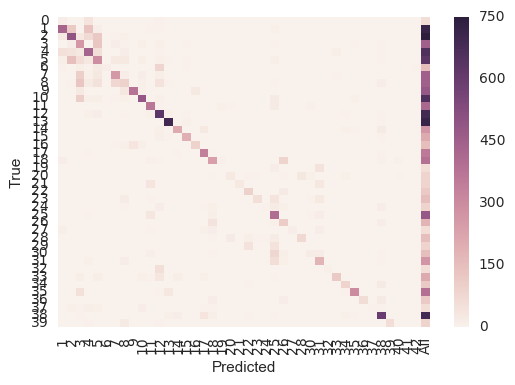

In [114]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns


confusion_table = pd.crosstab(y_test , prediction, rownames=['True'], colnames=['Predicted'], margins=True)
#print(confusion_table[0:41][0:42])

# Plot heat map for the confusion matrix
sns.heatmap(confusion_table[0:40][0:40])


evaluation = score(y_true =y_test, y_pred =prediction, labels = range(43))
evaluation2  = pd.DataFrame(np.transpose(evaluation), columns=['precision','recall', 'fbeta_score', 'support'])
print('Show first 5 classes performance scores:')
print(evaluation2[:][0:5])

In [107]:
confusion_table[0:41][0:42]

Predicted,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,All
True,,,,,,,,,,,,,,,,,,,,,
0,16,0,0,41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
1,432,116,1,135,16,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,720
2,24,493,29,68,123,0,4,8,0,0,...,0,0,0,0,0,0,0,0,0,750
3,0,13,263,0,126,0,13,4,0,8,...,0,3,0,0,3,0,0,0,0,450
4,52,46,29,436,54,0,0,17,0,1,...,0,0,0,0,5,0,0,0,0,660
5,10,147,56,31,291,0,26,25,1,11,...,1,0,0,0,4,0,0,0,0,630
6,4,0,9,3,22,16,1,2,0,0,...,0,0,0,0,1,0,1,0,4,150
7,0,1,105,6,28,0,258,17,0,16,...,0,0,0,0,0,0,1,0,0,450
8,0,4,126,23,49,0,79,96,0,7,...,0,0,0,0,15,0,0,0,0,450


## I spent trenmendous time for on this part due to, every time there's an error in input value (the test dataset or its label), the loaded seesion is not working. I have to re-run the model again. Any thoughts on this???
Ideally I think it should be able to load up and re-use, I just need to change the feed_dict. 

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Steps: download a few images from http://benchmark.ini.rub.de/?section=gtsrb&subsection=news. Store it in a 
### folder './OnlineTestData/'.Rename the images according to signnames.csv
from os import listdir
from os.path import isfile, join


test_path = './OnlineTestData/'

onlyfiles = [ f for f in listdir(test_path) if isfile(join(test_path,f)) ]
#test_img = np.empty(len(onlyfiles), dtype=object)
test_img = []
test_label=[]
for n in range(0, len(onlyfiles)):
    img = cv2.imread(join(test_path,onlyfiles[n]))
    # Get the file name without extension, convert to integer
    clas = int(os.path.splitext(onlyfiles[n])[0])
    test_label.append(clas)
    # Resize the image to be 32*32*3
    resize = cv2.resize(img, (32,32)) 
    test_img.append(cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY).reshape((32,32,1)))

test_label = np.array(test_label,dtype = int)

In [19]:
print('x training type is',type(x_training))
print('y training type is',type(y_training),y_training[0:5])
print('x training shape is',x_training[1].shape)

print()
print('x test type is',type(test_img))
print('y test type is',type(test_label),test_label)
print('x test shape is',test_img[1].shape)


x training type is <class 'list'>
y training type is <class 'numpy.ndarray'> [ 9  6 10 30 12]
x training shape is (32, 32, 1)

x test type is <class 'list'>
y test type is <class 'numpy.ndarray'> [13 14 34 35  4]
x test shape is (32, 32, 1)


### Predict the Sign Type for Each Image

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

sess = tf.Session()
new_saver = tf.train.import_meta_graph('lenet.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
test_accuracy = sess.run(accuracy_operation, feed_dict={x: test_img, y: test_label, keep_prob:0.8})

1.0


### Analyze Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Test Accuracy = {0:.0f}%".format(test_accuracy*100))

Test Accuracy = 100%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax = tf.nn.softmax(logits, dim=-1, name=None)
top_k_pred = tf.nn.top_k(softmax, k=5, name=None)
#in_top5 = tf.nn.in_top_k(softmax,y, k=1,  name=None)


#in_top5_pred = sess.run(in_top5, feed_dict={x: test_img, y: test_label})
top5_pred = sess.run(top_k_pred, feed_dict={x: test_img})

print(top5_pred)

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 